In [1]:
# basic imports
import pandas as pd, matplotlib.pyplot as plt, numpy as np 
import IPython.display as ipd

In [2]:
# librosa - for CQT and visualisation
import librosa, librosa.display

In [3]:
# Interval for label storage
from intervaltree import Interval,IntervalTree

# Neural Network Multilabel Classification

## Outline

We will make use of a neural network to help with automatic music transcription. We will train the model with a STFT array and the ground truth annotations for the music piece. Essentially for each frame in the audio signal we a CQT transform with 252 bins and a corresponding binary labels array of length 88.

**TYPE OF PROBLEM** - This type of problem is known a multi-label classification problem.

**INPUT**
- The input to the model is a Constant Q Transform (CQT) of the music data for each song. We are making use of a CQT because the frequency resolution in the lower ranges is better then a traditional STFT. The dimensions of the input array are determined by the number of frames and the number of bins/features of the CQT.

**OUTPUT**
- the output for each frame is a vector with 88 elements corresponding to the notes on a piano. A binary value of 1 corresponds to the note being active
- we will train the model on ground truth annotations

**GOAL** 
- to learn the weights by fitting the model to the data and optimizing the loss function 

**HYPER PARAMETERS TO TUNE** 
- number of layers 
- dropout rates
- number of neurons in hidden layers

We will make use of a dictionary data structure to iterate over different parameter values whilst keeping other parameters as set in the baseline model. 

## Import data

In [4]:
# import h5py to read in hdf5 files 
import h5py

filename ='musicnet.h5'
music_net = h5py.File(filename,'r')
type(music_net)

h5py._hl.files.File

In [7]:
# extract 3 songs from the database from the 21st index
i = 20 # start index
n = 3
source_list = list(music_net.keys())[i:n+i]
source_list

['id_1764', 'id_1765', 'id_1766']

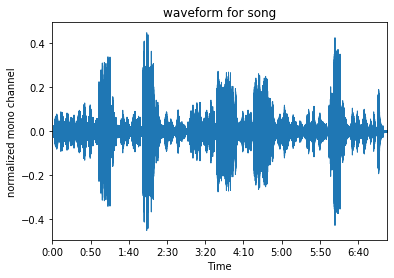

In [8]:
# plot the audio data 
librosa.display.waveplot(music_net[source_list[0]]['data'][()],
                         sr=44100,
                         x_axis= 'time');
plt.ylabel('normalized mono channel');
plt.title('waveform for song');

## Preprocessing

In [9]:
# init lists for storing results
cqt_container = [] # array to store the cqt for each song
cqt_shapes = [] # array to store the shapes of each cqt

print('initializing cqt transforms')
print('-'*60)
for id_ in source_list:
    print('extracting data from',id_)
    # extract the mono audio data and labels
    song = music_net[id_]
    music = song['data'][()]

    # downsampling
    sr = 44100
    sr_16k = 16000

    # resample to 16kHz to increase the the number of cqt points
    music = librosa.resample(music,sr,sr_16k)

    # CQT parameters
    sr_16k = sr_16k # downsampling to 16kHz
    hop_length = 512 # 32ms frames  
    bins_per_octave = 36 # corresponds to 7 octaves on the piano 
    # 7 x 36 = 252 number of bins 
    n_bins = 252 # frequency resolution 
    window = 'hann' # hanning window for smoothness

    # CQT absolute magnitude 
    C = np.abs(librosa.cqt(music,
                           sr = sr_16k , 
                           hop_length = hop_length,
                           bins_per_octave = bins_per_octave,
                           window = window,
                           n_bins = n_bins))
    # transpose to get the array in the correct format
    C = np.transpose(C)
    
    # append the length of this cqt to the length array 
    cqt_shapes.append(C.shape)
    
    # append to container
    cqt_container.append(C)

print('-'*60)
print('CQT transformation on each song complete')
print('-'*60)
print('CQT dimensions:', cqt_shapes)

initializing cqt transforms
------------------------------------------------------------
extracting data from id_1764
extracting data from id_1765
extracting data from id_1766
------------------------------------------------------------
CQT transformation on each song complete
------------------------------------------------------------
CQT dimensions: [(13696, 252), (21144, 252), (13356, 252)]


In [10]:
# extract and format labels 
labels_container = [] # array to store the labels of each song
labels_shapes = [] # array for storing label dimensions

# set up params for labels 
number_of_notes = 88 ## 88 piano notes 
hop_length = 512 # 32ms frames  
# counter to loop through cqt container 
i = 0 

print('constructing label vectors')
print('-'*60)

for id_ in source_list:
    # retrieve the song for this id 
    song = music_net[id_]
    raw_labels = song['labels'][()]
    
    # number of frames in this song
    number_frames = cqt_container[i].shape[0]
    i += 1  
    
    # binary labels - one hot encoding
    binary_labels = np.zeros((number_frames, number_of_notes))

    # init tree for slicing
    labels_tree = IntervalTree()
    # construct interval tree 
    for label in raw_labels: 
        pitch = label['note_id']
        start_time = label['start_time']
        end_time = label['end_time']
        labels_tree.addi(start_time,end_time,pitch)

    # resample the labels by finding the number of frames per second
    for frame in range(binary_labels.shape[0]):
        # slice the interval tree for notes in this frame 
        labels = labels_tree.at(frame*hop_length)
        for label in labels:
            # the labels vector is from 0 to 87 
            # 21 is the A0 on the piano
            pitch = label[2]-21 
            # if this pitch is active in this window 
            binary_labels[frame,pitch] = 1
    
    # append the binary_labels
    labels_container.append(binary_labels)
    # store label shapes 
    labels_shapes.append(binary_labels.shape)

print('labels preprocessed')
print('-'*60)
print('labels dimensions:', labels_shapes)

constructing label vectors
------------------------------------------------------------
labels preprocessed
------------------------------------------------------------
labels dimensions: [(13696, 88), (21144, 88), (13356, 88)]


In [11]:
# stack the containers vertically
X = np.vstack(cqt_container)
y = np.vstack(labels_container)

## train-test split and normalization

In [12]:
# split into training and test 
from sklearn.model_selection import train_test_split

# split into train, test and validation 
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
# # need to set split = 0.25 to get 60-20-20 split 
X_train, X_val, y_train, y_val = train_test_split(X_train_val,y_train_val, test_size=0.25, random_state=42)

In [13]:
# Normalization - to test sets having values 
# outside training test range
max_train = X_train.max()
min_train = X_train.min()
max_val = X_val.max()
min_val = X_val.min()
max_test = X_test.max()
min_test = X_test.min()

# normalize
X_val_norm = (X_val - min_train)/(max_train - min_train)
X_test_norm = (X_test - min_train)/(max_train - min_train)
X_train_norm = (X_train - min_train)/(max_train - min_train)

# Compute the mean
train_mean = np.mean(X_train_norm, axis = 0)

# Substract it
X_train_norm = X_train_norm - train_mean
X_val_norm = X_val_norm - train_mean
X_test_norm = X_test_norm - train_mean

# reassign for easy interpretation 
X_train = X_train_norm
X_val = X_val_norm
X_test = X_test_norm

## Multilabel architecture

### Appropriate loss function for imbalanced multi-label classification

In [17]:
# balanced loss function for multi-label problem
    
import tensorflow as tf
import keras.backend.tensorflow_backend as tfb

POS_WEIGHT = 10  # multiplier for positive targets, there are approximately 10-15 times as many inactive notes to active notes in the dataset per frame

def weighted_binary_crossentropy(target, output):
    """
    Weighted binary crossentropy between an output tensor 
    and a target tensor. POS_WEIGHT is used as a multiplier 
    for the positive targets.

    Combination of the following functions:
    * keras.losses.binary_crossentropy
    * keras.backend.tensorflow_backend.binary_crossentropy
    * tf.nn.weighted_cross_entropy_with_logits
    """
    # transform back to logits
    _epsilon = tfb._to_tensor(tfb.epsilon(), output.dtype.base_dtype)
    output = tf.clip_by_value(output, _epsilon, 1 - _epsilon)
    output = tf.math.log(output / (1 - output))
    # compute weighted loss
    loss = tf.nn.weighted_cross_entropy_with_logits(labels=target,
                                                    logits=output,
                                                    pos_weight=POS_WEIGHT)
    return tf.reduce_mean(loss, axis=-1)

# reference - https://stackoverflow.com/questions/42158866/neural-network-for-multi-label-classification-with-large-number-of-classes-outpu

### Appropriate metric for multilabel classification tasks

In [18]:
from keras import backend as K

def f1_score(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Baseline model definition 

In [19]:
# model definition  
from keras.layers import Dense, Dropout
from keras.models import Sequential 
import keras.optimizers as KO
from keras.layers import BatchNormalization

# default hyperparameters for model
layers = 3 # layers of model 
nn = 256 # nodes
lr = 0.001 # learning rate
act ='relu' # activation functions
drop = 0.1 # dropout rate to improve test error perf

# default static parameters
num_col = 252 # inputs 
output_nodes = 88 # outputs 
loss = weighted_binary_crossentropy # loss function for use in back propagation

# define model with params
def create_model(layers=layers,nn=nn,lr=lr,act=act,drop=drop):  
  # Create an Adam optimizer with the given learning rate
  opt = KO.Adam(lr=lr)
  # create model 
  model = Sequential()
  # input layer
  model.add(Dense(num_col,kernel_initializer='normal', 
                  activation=act ,input_shape=(num_col,)))
  model.add(Dropout(drop))
  model.add(BatchNormalization())
    
  for i in range(layers):
    # layers with dropout and batch normalization 
    model.add(Dense(nn, activation=act,
                    kernel_initializer = 'normal'))
    model.add(Dropout(drop))
    model.add(BatchNormalization())
  
  # output layer - we require a sigmoid activation function 
  model.add(Dense(output_nodes, activation='sigmoid',kernel_initializer='normal'))
    
  # compile model
  model.compile(optimizer=opt, loss=loss, metrics=[f1_score])
    
  return model

## Hyperparameter Tuning

### Function for building model and running with different parameters

In [20]:
# Callbacks 
from keras.callbacks import EarlyStopping

def build_run_model(layers=3, drop=0.1, nn=256):
    model = create_model(layers=layers, drop=drop, nn=nn)
    
    # batch size and epoch
    batch_size = 32 # mini batch size - compromise between efficiency and error
    # only a small number of epochs is needed for hyperparameter tuning     
    epochs = 5 # number of times to iterate through the dataset
    
    # patience determines how long before the model stops training after seeing no improvement
    early_stopping_monitor = EarlyStopping(patience=10,mode='auto', verbose=1, min_delta=0, monitor='val_loss')
    
    model.fit(X_train,y_train,validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size,
                        callbacks=[early_stopping_monitor], verbose=1)
    
    return model.history

### Fitting model for different parameters

In [21]:
results = {}

# parameters for tuning
params = { 
          'layers' : [2,3,4],
          'drop': [0, 0.1,0.2],
          'nn': [128,256, 512]
}

# iterate through different parameters
for param in params:
    if param not in results.keys():
        results[param] = {}
        for value in params[param]:
            if param=='layers':
                # run and compile model and log the history object in the               
                results[param][value] = build_run_model(layers=value)
            elif param=='drop':
                results[param][value] = build_run_model(drop=value)
            elif param=='nn':
                results[param][value] = build_run_model(nn=value)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 28917 samples, validate on 9639 samples
Epoch 1/5
28917/28917 [==============================] - 14s 470us/step - loss: 0.5593 - f1_score: 0.2649 - val_loss: 0.4749 - val_f1_score: 0.3006
Epoch 2/5
28917/28917 [==============================] - 12s 408us/step - loss: 0.4596 - f1_score: 0.3178 - val_loss: 0.4294 - val_f1_score: 0.3360
Epoch 3/5
28917/28917 [==============================] - 12s 404us/step - loss: 0.4271 - f1_score: 0.3408 - val_loss: 0.3992 - val_f1_score: 0.3563
Epoch 4/5
28917/28917 [==============================] - 12s 407us/step - loss: 0.4032 - f1_score: 0.3595 - val_loss: 0.3770 - val_f1_score: 0.3703
Epoch 5/5
28917/28917 [==============================] - 12s 407us/step - loss: 0.3845 - f1_score: 0.3763 - val_loss: 0.3584 - val_f1_score: 0.3868
Train on 28917 samples, validate on 9639 samples
Epoch 1/5
28917/28917 [==============================] - 17s 590us/

In [22]:
# dictionary with different params and associated information on model evaluation as an keras object
# leaving the results in this form is more flexible then directly extracting the values
results

{'layers': {2: <keras.callbacks.callbacks.History at 0x14c86c00d48>,
  3: <keras.callbacks.callbacks.History at 0x14c8810af08>,
  4: <keras.callbacks.callbacks.History at 0x14c8993a4c8>},
 'drop': {0: <keras.callbacks.callbacks.History at 0x14c8ec1ef88>,
  0.1: <keras.callbacks.callbacks.History at 0x14c901daec8>,
  0.2: <keras.callbacks.callbacks.History at 0x14c9195ff48>},
 'nn': {128: <keras.callbacks.callbacks.History at 0x14c930f7b48>,
  256: <keras.callbacks.callbacks.History at 0x14c949deac8>,
  512: <keras.callbacks.callbacks.History at 0x14c981939c8>}}

In [24]:
# Store f1 and loss results
# layers param
layers_vals = []
layers_f1 = [] 
layers_loss = []

# dropout param
drop_vals = []
drop_f1 = []
drop_loss = []

# nn param
nn_vals = []
nn_f1 = []
nn_loss = []

# iterate through different parameters
for param in results:
        for val in results[param]:
            if param =='layers':
                f1_score = round(results[param][val].history["val_f1_score"][-1],3)
                loss_score =round(results[param][val].history["val_loss"][-1],3)
                layers_vals.append(val)
                layers_f1.append(f1_score)
                layers_loss.append(loss_score)
            elif param =='drop': 
                f1_score = round(results[param][val].history["val_f1_score"][-1],3)
                loss_score =round(results[param][val].history["val_loss"][-1],3)
                drop_vals.append(val)
                drop_f1.append(f1_score)
                drop_loss.append(loss_score)
            elif param =='nn': 
                f1_score = round(results[param][val].history["val_f1_score"][-1],3)
                loss_score = round(results[param][val].history["val_loss"][-1],3)
                nn_vals.append(val)
                nn_f1.append(f1_score)
                nn_loss.append(loss_score)

In [28]:
# layers table
layers_table = pd.DataFrame(zip(layers_vals,layers_f1,layers_loss), columns =['layers', 'validation f1-measure','validation loss score'])
layers_table.set_index('layers',inplace=True)
layers_table

,validation f1-measure,validation loss score
layers,,
2,0.387,0.358
3,0.379,0.371
4,0.348,0.411


In [29]:
# dropout table
drop_table = pd.DataFrame(zip(drop_vals,drop_f1,drop_loss), columns =['Dropout Rate', 'validation f1-measure','validation loss score'])
drop_table.set_index('Dropout Rate',inplace=True)
drop_table

,validation f1-measure,validation loss score
Dropout Rate,,
0.0,0.449,0.320
0.1,0.380,0.367
0.2,0.345,0.409


In [30]:
# layers values
nn_table = pd.DataFrame(zip(nn_vals,nn_f1,nn_loss), columns =['Neurons in hidden layers', 'validation f1-measure','validation loss score'])
nn_table.set_index('Neurons in hidden layers',inplace=True)
nn_table

,validation f1-measure,validation loss score
Neurons in hidden layers,,
128,0.357,0.399
256,0.382,0.372
512,0.416,0.334


### Conclusions

Optimal values to use in model
- **number of neurons per layer** : 512 (f1-measure : 0.416, loss : 0.334)
- **Dropout Rate** : 0.1 (f1-measure : 0.380, loss : 0.367)
- **layers** : 2 (f1-measure : 0.387, loss : 0.358)

## Making use of tuned hyperparameters

### Redefine loss function and f1 metric for tuned model to avoid namespace conflicts

In [34]:
# balanced loss function for multi-label problem
    
import tensorflow as tf
import keras.backend.tensorflow_backend as tfb

POS_WEIGHT = 10  # multiplier for positive targets, needs to be tuned

def weighted_binary_crossentropy(target, output):
    """
    Weighted binary crossentropy between an output tensor 
    and a target tensor. POS_WEIGHT is used as a multiplier 
    for the positive targets.

    Combination of the following functions:
    * keras.losses.binary_crossentropy
    * keras.backend.tensorflow_backend.binary_crossentropy
    * tf.nn.weighted_cross_entropy_with_logits
    """
    # transform back to logits
    _epsilon = tfb._to_tensor(tfb.epsilon(), output.dtype.base_dtype)
    output = tf.clip_by_value(output, _epsilon, 1 - _epsilon)
    output = tf.math.log(output / (1 - output))
    # compute weighted loss
    loss = tf.nn.weighted_cross_entropy_with_logits(labels=target,
                                                    logits=output,
                                                    pos_weight=POS_WEIGHT)
    return tf.reduce_mean(loss, axis=-1)

# reference - https://stackoverflow.com/questions/42158866/neural-network-for-multi-label-classification-with-large-number-of-classes-outpu

In [35]:
from keras import backend as K

def f1_score(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Tuned model definition 

In [36]:
# model definition  
from keras.layers import Dense, Dropout
from keras.models import Sequential 
import keras.optimizers as KO
from keras.layers import BatchNormalization

# parameters from tuning
layers = 2 # layers of model 
nn = 512 # nodes
lr = 0.001 # learning rate
act ='relu' # activation functions
drop = 0.1 # dropout rate to improve test error perf

# default static parameters
num_col = 252 # inputs 
output_nodes = 88 # outputs 
loss = weighted_binary_crossentropy # loss function for use in back propagation

# define model with params
def create_model(layers=layers,nn=nn,lr=lr,act=act,drop=drop):  
  # Create an Adam optimizer with the given learning rate
  opt = KO.Adam(lr=lr)
  # create model 
  model = Sequential()
  # input layer
  model.add(Dense(num_col,kernel_initializer='normal', 
                  activation=act ,input_shape=(num_col,)))
  model.add(Dropout(drop))
  model.add(BatchNormalization())
    
  for i in range(layers):
    # layers with dropout and batch normalization 
    model.add(Dense(nn, activation=act,
                    kernel_initializer = 'normal'))
    model.add(Dropout(drop))
    model.add(BatchNormalization())
  
  # output layer - we require a sigmoid activation function 
  model.add(Dense(output_nodes, activation='sigmoid',kernel_initializer='normal'))
    
  # compile model
  model.compile(optimizer=opt, loss=loss, metrics=[f1_score])
    
  return model

### Fit the tuned model 

In [37]:
# fit tuned model

final_model = create_model()

# batch size
batch_size = 32 # mini batch size - compromise between efficiency and error

# here we will use a much larger number of epochs for 
# training compared to the parameter tuning  
epochs = 70 

# patience determines how long before the model stops training after seeing no improvement
early_stopping_monitor = EarlyStopping(patience=10,mode='auto', verbose=1, min_delta=0, monitor='val_loss')

final_model.fit(X_train,y_train,validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size,
                    callbacks=[early_stopping_monitor], verbose=1)


Train on 28917 samples, validate on 9639 samples
Epoch 1/100
28917/28917 [==============================] - 30s 1ms/step - loss: 0.5618 - f1_score: 0.2636 - val_loss: 0.4625 - val_f1_score: 0.3144
Epoch 2/100
28917/28917 [==============================] - 28s 954us/step - loss: 0.4522 - f1_score: 0.3235 - val_loss: 0.4234 - val_f1_score: 0.3377
Epoch 3/100
28917/28917 [==============================] - 27s 938us/step - loss: 0.4129 - f1_score: 0.3534 - val_loss: 0.3917 - val_f1_score: 0.3646
Epoch 4/100
28917/28917 [==============================] - 27s 932us/step - loss: 0.3840 - f1_score: 0.3771 - val_loss: 0.3640 - val_f1_score: 0.3857
Epoch 5/100
28917/28917 [==============================] - 27s 935us/step - loss: 0.3629 - f1_score: 0.3948 - val_loss: 0.3357 - val_f1_score: 0.4164
Epoch 6/100
28917/28917 [==============================] - 27s 945us/step - loss: 0.3428 - f1_score: 0.4144 - val_loss: 0.3215 - val_f1_score: 0.4211
Epoch 7/100
28917/28917 [============================

### Model history and performances

In [38]:
h = final_model.history

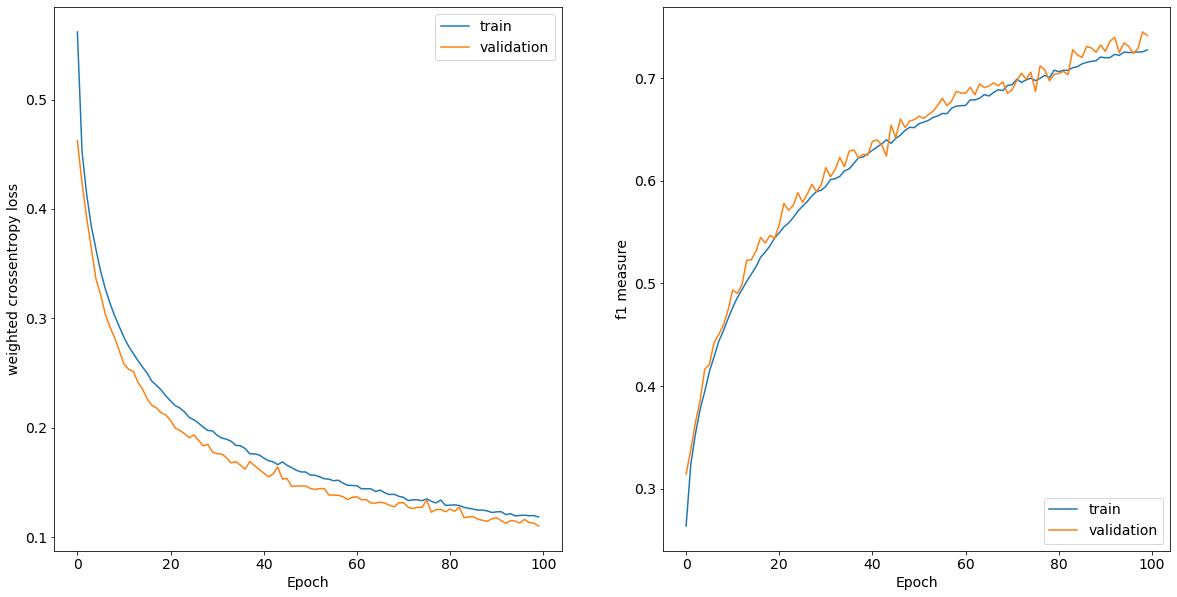

In [59]:
plt.figure(figsize=(20,10))

# use the test set and validate 
plt.subplot(121)

# use the history metrics 
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])

plt.ylabel('weighted crossentropy loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['train','validation'],fontsize=14);

plt.subplot(122)
# use the history metrics 
plt.plot(h.history['f1_score'])
plt.plot(h.history['val_f1_score'])

plt.ylabel('f1 measure',fontsize=14)
plt.xlabel('Epoch',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['train','validation'], loc='lower right',fontsize=14);
plt.show()